In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Processamento de Dados

## Variáveis Continuas

### Scalers

In [16]:
from sklearn.preprocessing import StandardScaler


## Variáveis Categóricas

## Variáveis de Data

# Modelos Não-Supervisionados

**Aulas** 
* `aulas/64 DA PT NOV-2021 Aula 20220317 PCA.ipynb`
* `aulas/64 DA PT NOV-2021 Aula 20220324 Unsupervised Learning I.ipynb`
* `aulas/64 DA PT NOV-2021 Aula 20220324 Unsupervised Learning II.ipynb`
* `aulas/64 DA PT NOV-2021 Aula 20220324 Unsupervised Learning III.ipynb`


**Case**
* **Padrões de Movimento de Urubus (Aglomerativo):** `cases/Padrões de Movimento - Urubu.ipynb` 
* **Padrões de Movimento de Zebras (DBSCAN/HDBSCAN):** `cases/Padrões de Movimento - Zebras.ipynb`

## Carregando dados

In [62]:
tb_wine = pd.read_csv("data/wine-clustering.csv")
wine_scaler = StandardScaler()
wine_scaler.fit(tb_wine)


StandardScaler()

## Projeções (PCA)

In [39]:
from sklearn.decomposition import PCA


### Escolhendo número de componentes

In [44]:
pca_wine = PCA()
pca_wine.fit(wine_scaler.transform(tb_wine))  # SEMPRE FAZER PCA COM DADOS NORMALIZADOS


PCA()

Scree plot representa quantos % da variância total das variáveis cada componente representa

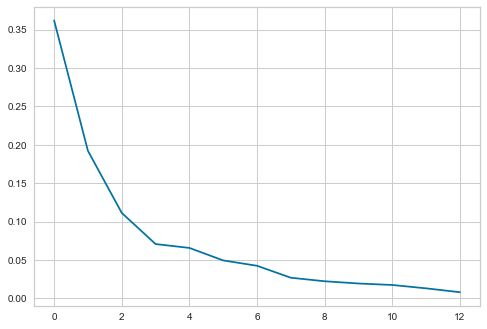

In [45]:
plt.plot(pca_wine.explained_variance_ratio_)


#### Método do cotovelo

In [46]:
from kneed import KneeLocator


Método do cotovelo sugere: 4 Componentes


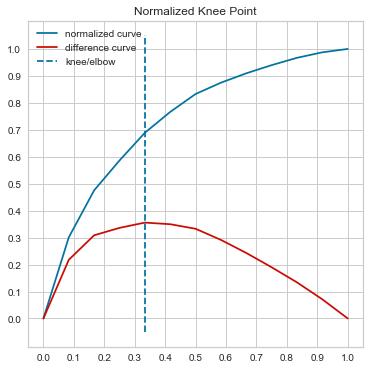

In [50]:
knee_fit = KneeLocator(
    range(len(pca_wine.explained_variance_ratio_)), # vetor com número dos componentes de 0 à 12
    np.cumsum(pca_wine.explained_variance_ratio_), # soma acumulada da variância explicada por cada componente
)
print(f"Método do cotovelo sugere: {knee_fit.knee} Componentes")
knee_fit.plot_knee_normalized();

#### Estimando Componentes

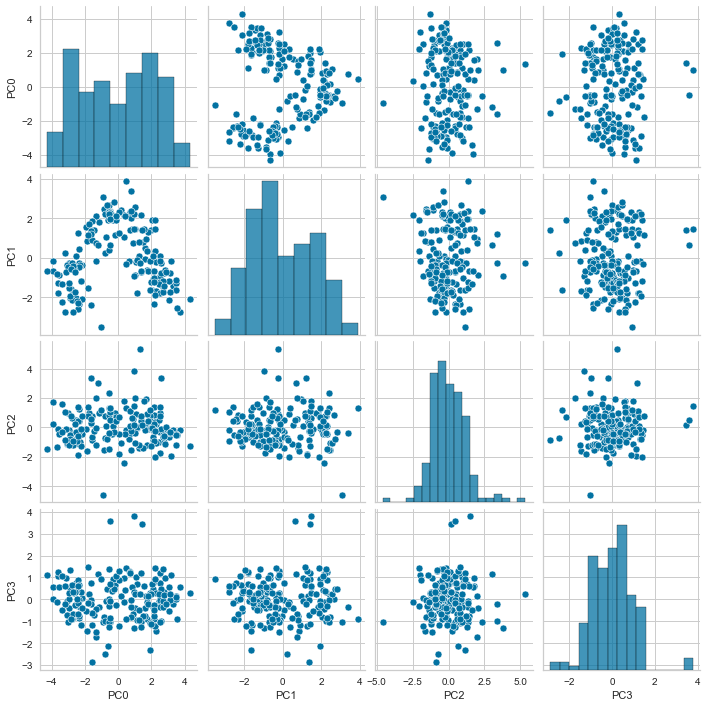

In [53]:
pca_wine = PCA(n_components = knee_fit.knee)
ar_pca_wine = pca_wine.fit_transform(wine_scaler.transform(tb_wine)) # SEMPRE NORMALIZAR DADOS ANTES DE PCA
tb_pca_wine = pd.DataFrame(ar_pca_wine, columns = ['PC' + str(i) for i in range(knee_fit.knee)])
sns.pairplot(tb_pca_wine)

## KMeans

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


### Escolhendo número de clusters

#### Método do Cotovelo
Yellowbrick está dando um erro bizarro (parece incompatibilidade com a versão do sklearn)...

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

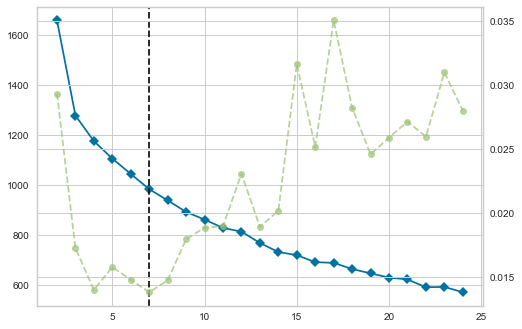

In [54]:
kmeans_fit = KMeans()
kmeans_viz = KElbowVisualizer(KMeans(), k=(2, 25))
kmeans_viz.fit(wine_scaler.transform(tb_wine)) # SEMPRE NORMALIZAR ANTES DE KMEANS


### Fazendo fit

In [55]:
kmeans_fit = KMeans(n_clusters=4)
kmeans_fit.fit(wine_scaler.transform(tb_wine))

KMeans(n_clusters=4)

### Extraindo clusters

In [63]:
tb_pca_wine["km_clu"] = kmeans_fit.labels_
# ou tb_wine['km_clu'] = kmeans_fit.predict(tb_sca_wine)

### Utilizando PCA para visualizar resultados

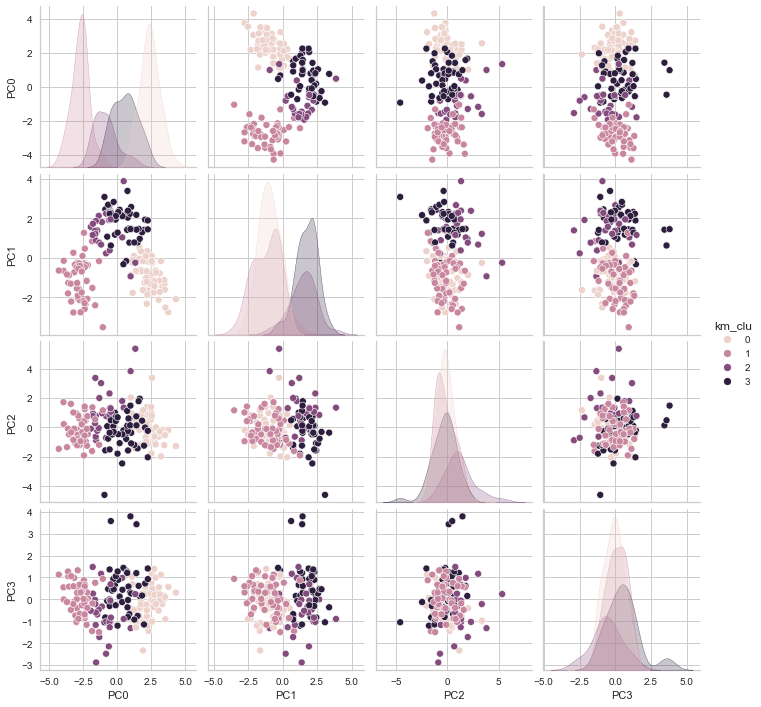

In [64]:
sns.pairplot(data=tb_pca_wine, hue="km_clu")


## Aglomerativo (Hierariquico)

**Padrões de voos de urubus:** `cases/Padrões de Movimento - Urubu.ipynb`

### Construindo dendograma

In [65]:
from scipy.cluster.hierarchy import dendrogram, linkage

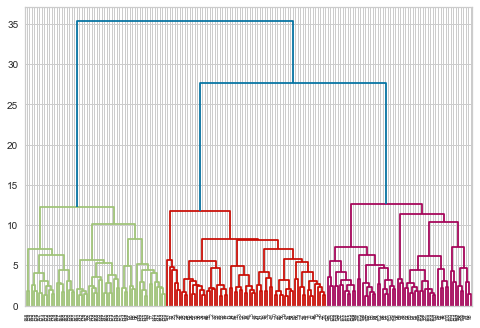

In [68]:
dendrogram_ = dendrogram(linkage(wine_scaler.transform(tb_wine), method = 'ward'))

### 'Cortando' dendograma

In [72]:
from sklearn.cluster import AgglomerativeClustering

In [73]:
hierarchical = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
hierarchical.fit(wine_scaler.transform(tb_wine))
tb_pca_wine['ward_clu'] = [str(x) for x in hierarchical.labels_]

### Visualizando usando PCA

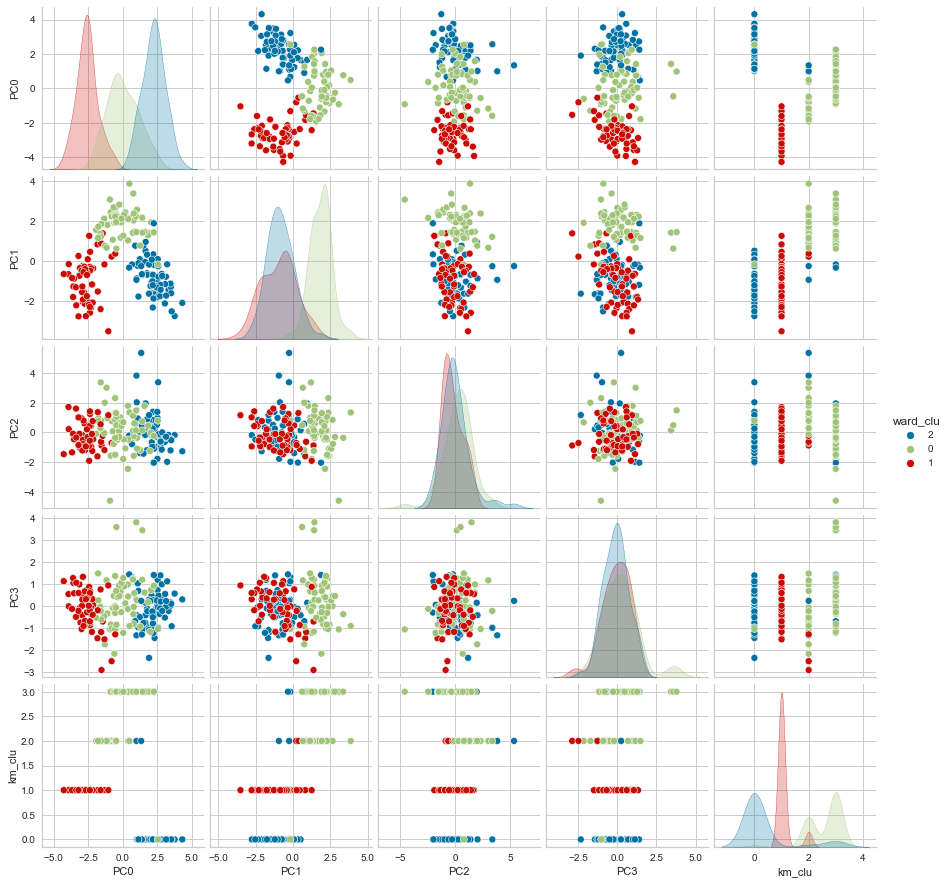

In [74]:
sns.pairplot(data=tb_pca_wine, hue="ward_clu")


## DBSCAN

# Modelos Supervisionados

## Classificação

**Aulas**
* `aulas/64 DA PT NOV-2021 Aula 20220329 Regressão Logistica.ipynb`
* `aulas/64 DA PT NOV-2021 Aula 20220331 Métodos de Classificação.ipynb`

**Cases**
* `cases/64 DA PT NOV-2021 Case Hotel.ipynb`

### Regressão Logística

### Árvores de Decisão

### Métodos de Ensemble

#### Bagging

#### Boosting

## Regressão

### Regressão Linear

### Regressões Regularizadas

#### LASSO

#### Ridge

### Métodos de Ensemble

#### Bagging

#### Boosting